In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd

# Read the dataset from CSV
df = pd.read_csv('/content/gdrive/MyDrive/phase 2/mins.csv')

# Sort the DataFrame by 'impossible' score within each user group
df_sorted = df.groupby('userId').apply(lambda x: x.sort_values('impossible'))

# Function to select bottom n rows for each group
def select_bottom_n(df, n):
    return df.head(n)

# Calculate the number of rows to select for each user (20% of total ratings)
rows_to_select = df_sorted.groupby('userId').size() * 0.20

# Select bottom 20% of 'impossible' scores for each user
bottom_20_percent = df_sorted.groupby('userId').apply(lambda x: select_bottom_n(x, n=int(rows_to_select[x.name])))

# Select only required columns
bottom_20_percent = bottom_20_percent[['userId', 'movieId', 'impossible']]

# Save to CSV
bottom_20_percent.to_csv("/content/gdrive/MyDrive/phase 2/bottom_20_percent_impossible_scores.csv", index=False)


In [ ]:
import pandas as pd

# Read the dataset from CSV
df = pd.read_csv('/content/gdrive/MyDrive/phase 2/mins.csv')

# Group by userId and sort by serendipity score
grouped = df.groupby('userId').apply(lambda x: x.sort_values('serendipity_score', ascending=False))

# Reset the index after grouping
grouped.reset_index(drop=True, inplace=True)

# Function to select top n rows for each group
def select_top_n(df, n):
    return df.head(n)

# Calculate the number of ratings to select for each user (20% of total ratings)
ratings_to_select = grouped.groupby('userId').size() * 0.20

# Select top 20% serendipity scores for each user
top_k_serendipity = grouped.groupby('userId').apply(lambda x: select_top_n(x, n=int(ratings_to_select[x.name])))

# Select only required columns
top_k_serendipity = top_k_serendipity[['userId', 'movieId', 'serendipity_score']]

# Save to CSV
top_k_serendipity.to_csv("/content/gdrive/MyDrive/phase 2/top_20_percent_serendipity_scores.csv", index=False)


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import logging, os

In [ ]:
ratings=pd.read_csv('/content/gdrive/MyDrive/phase 2/ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [ ]:
#twentyimpo=pd.read_csv('/content/gdrive/MyDrive/phase 2/top_k_serendipity_scores_s10.csv')

In [ ]:
#twentyimpo.head()

In [ ]:
#import pandas as pd

#Sample DataFrames


#df1 = pd.read_csv('/content/gdrive/MyDrive/phase 2/ratings.csv')
#df2 = pd.read_csv('/content/gdrive/MyDrive/phase 2/top_k_serendipity_scores_s10.csv')
#df2=  pd.read_csv('/content/gdrive/MyDrive/phase 2/bottom_20_percent_impossible_scores.csv')
# Merge the dataframes on userId and movieId
#merged_df = pd.merge(df1, df2, on=['userId', 'movieId'], how='left')

# Update ratings in df1 with a rating of 5 where ratings are missing
#merged_df['rating'].fillna(5, inplace=True)

# Drop the 'impossible' column if needed
#merged_df.drop(columns=['impossible'], inplace=True, errors='ignore')

# Print the updated DataFrame
#print(merged_df)


In [ ]:
import pandas as pd

# Sample DataFrames
df1 = pd.read_csv('/content/gdrive/MyDrive/phase 2/ratings.csv')
df2 = pd.read_csv('/content/gdrive/MyDrive/phase 2/top_k_serendipity_scores_s20.csv')
df3 = pd.read_csv('/content/gdrive/MyDrive/phase 2/bottom_10_percent_impossible_scores.csv')

# Step 1: Set rating to 5 for all movies for each user in df2
df2['rating'] = 5

# Step 2: Set rating to 0 for all movies for each user in df3
df3['rating'] = 0

# Step 3: Merge df2 and df3 with df1 based on 'userId' and 'movieId'
merged_df = pd.concat([df1, df2, df3], ignore_index=True)

# Step 4: Update ratings in merged_df as per ratings from df2 and df3
merged_df.drop_duplicates(subset=['userId', 'movieId'], keep='last', inplace=True)  # Keep only the last rating for each user-movie pair

# Step 5: Save the merged DataFrame to a new CSV file
merged_df.to_csv('/content/gdrive/MyDrive/phase 2/merged_ratings.csv', index=False)


In [ ]:
training_full=merged_df

In [ ]:
print(training_full.columns)


Index(['userId', 'movieId', 'rating', 'timestamp', 'serendipity_score',
       'impossible'],
      dtype='object')


In [ ]:
training_full

,userId,movieId,rating,timestamp,serendipity_score,impossible
0,196.0,242.0,3,881250949.0,NaN,NaN
1,186.0,302.0,3,891717742.0,NaN,NaN
3,244.0,51.0,2,880606923.0,NaN,NaN
4,166.0,346.0,1,886397596.0,NaN,NaN
6,115.0,265.0,2,881171488.0,NaN,NaN
...,...,...,...,...,...,...
369023,943.0,959.0,0,NaN,NaN,0.505570
369024,943.0,1358.0,0,NaN,NaN,0.506265
369025,943.0,649.0,0,NaN,NaN,0.507759
369026,943.0,1120.0,0,NaN,NaN,0.510785


In [ ]:
print(training_full.columns)

Index(['userId', 'movieId', 'rating', 'timestamp', 'serendipity_score',
       'impossible'],
      dtype='object')


In [ ]:
correct_column_names = [col for col in training_full.columns if 'UserId' in col]
print(correct_column_names)

[]


In [ ]:
user_ids = training_full['userId'].unique().tolist()


In [ ]:
# Drop unnecessary columns
cols_to_drop = ['timestamp']
#training_full.drop(cols_to_drop, axis = 1, inplace = True)
training_full.head()

user_ids = training_full["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}
movie_ids = training_full["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}
training_full["user"] = training_full["userId"].map(user2user_encoded)
training_full["movie"] = training_full["movieId"].map(movie2movie_encoded)

num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
training_full["rating"] = training_full["rating"].values.astype(np.float32)
# min and max ratings will be used to normalize the ratings later
min_rating = min(training_full["rating"])
max_rating = max(training_full["rating"])

print(
    "Number of users: {}, Number of Movies: {}, Min rating: {}, Max rating: {}".format(
        num_users, num_movies, min_rating, max_rating
    )
)

training_full = training_full.sample(frac=1, random_state=42)
x = training_full[["user", "movie"]].values
# Normalize the targets between 0 and 1. Makes it easy to train.
y = training_full["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
# Assuming training on 80% of the data and validating on 20%.
train_indices = int(0.8 * training_full.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)



Number of users: 943, Number of Movies: 1682, Min rating: 0.0, Max rating: 5.0


In [ ]:
EMBEDDING_SIZE = 64

In [ ]:
class RecommenderNet(keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size
        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.user_bias = layers.Embedding(num_users, 1)
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        self.movie_bias = layers.Embedding(num_movies, 1)

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])
        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        # Add all the components (including bias)
        x = dot_user_movie + user_bias + movie_bias
        # The sigmoid activation forces the rating to between 0 and 1
        return tf.nn.sigmoid(x)


model = RecommenderNet(num_users, num_movies, EMBEDDING_SIZE)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
)

history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=64,
    epochs=11,
    verbose=1,
    validation_data=(x_val, y_val),
)

Epoch 1/11
4363/4363 [==============================] - 23s 5ms/step - loss: 0.5043 - val_loss: 0.4045
Epoch 2/11
4363/4363 [==============================] - 22s 5ms/step - loss: 0.3563 - val_loss: 0.3251
Epoch 3/11
4363/4363 [==============================] - 21s 5ms/step - loss: 0.3075 - val_loss: 0.2982
Epoch 4/11
4363/4363 [==============================] - 21s 5ms/step - loss: 0.2919 - val_loss: 0.2881
Epoch 5/11
4363/4363 [==============================] - 20s 5ms/step - loss: 0.2869 - val_loss: 0.2860
Epoch 6/11
4363/4363 [==============================] - 21s 5ms/step - loss: 0.2861 - val_loss: 0.2851
Epoch 7/11
4363/4363 [==============================] - 20s 4ms/step - loss: 0.2861 - val_loss: 0.2868
Epoch 8/11
4363/4363 [==============================] - 21s 5ms/step - loss: 0.2861 - val_loss: 0.2892
Epoch 9/11
4363/4363 [==============================] - 21s 5ms/step - loss: 0.2870 - val_loss: 0.2890
Epoch 10/11
4363/4363 [==============================] - 23s 5ms/step - l

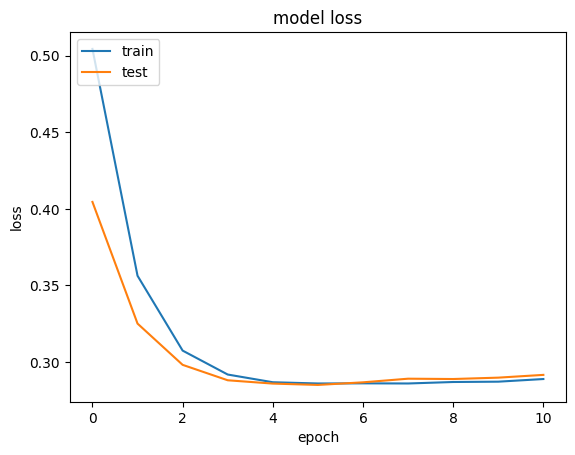

In [ ]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
movie_df=pd.read_csv(r'/content/gdrive/MyDrive/phase 2/movies.csv')


In [ ]:
print(movie_df.columns)

Index(['movieId', 'title', 'genre'], dtype='object')


In [ ]:
# Initialize a set to store all recommended items
all_recommended_items = set()
user_item_interactions = ratings[['userId', 'movieId']]

def generate_recommendations(user_id, model, movie_df, movie2movie_encoded, user2user_encoded, movie_encoded2movie):
    movies_watched_by_user = training_full[training_full.userId == user_id]
    movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-20:][::-1]
    recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]
    return recommended_movie_ids



# Generate recommendations for each user and collect all recommended items
for user_id in user_item_interactions['userId'].unique():
    recommended_items = generate_recommendations(user_id, model, movie_df, movie2movie_encoded, user2user_encoded, movie_encoded2movie)
    all_recommended_items.update(recommended_items)

cold_start_threshold = 30  # For example, an item with fewer than 30 interactions may be considered a cold start item

# Group interactions by item and count the number of interactions for each item
item_interaction_counts = user_item_interactions['movieId'].value_counts()

# Identify cold start items based on the threshold
cold_start_items = item_interaction_counts[item_interaction_counts < cold_start_threshold].index.tolist()

# Initialize a set to store cold start items exposed to at least one user
exposed_cold_start_items = set()

# Check each recommended item against the cold start items list and collect exposed cold start items
for item in all_recommended_items:
    if item in cold_start_items:
        exposed_cold_start_items.add(item)

# Calculate the exposure ratio for cold start items
exposure_ratio = len(exposed_cold_start_items) / len(cold_start_items)

print("Exposure Ratio for Cold Start Items:", exposure_ratio)
exposure_ratio_percentage = exposure_ratio * 100

print("Exposure Ratio for Cold Start Items: {:.2f}%".format(exposure_ratio_percentage))

# Initialize variables to store total categories and total recommended items
total_categories = 0
total_recommendation_items = 0

# Iterate over unique user IDs
for user_id in user_item_interactions['userId'].unique():
    # Generate recommendations for the current user
    recommended_items = generate_recommendations(user_id, model, movie_df, movie2movie_encoded, user2user_encoded, movie_encoded2movie)

    # Increment total recommended items count
    total_recommendation_items += len(recommended_items)

    # Extract genres for recommended items and store unique genres
    recommended_genres = set()
    for item_id in recommended_items:
        genres = movie_df[movie_df['movieId'] == item_id]['genre'].values[0].split('|')
        recommended_genres.update(genres)

    # Increment total categories count
    total_categories += len(recommended_genres)

# Calculate diversity
diversity = total_categories / total_recommendation_items

print("Diversity for the recommendation system: {:.2f}".format(diversity))



# Calculate diversity in percentage
diversity_percentage = diversity * 100

print("Diversity for the recommendation system: {:.2f}%".format(diversity_percentage))




45/45 [==============================] - 0s 1ms/step
Exposure Ratio for Cold Start Items: 0.16095890410958905
Exposure Ratio for Cold Start Items: 16.10%
45/45 [==============================] - 0s 4ms/step
Diversity for the recommendation system: 0.58
Diversity for the recommendation system: 58.19%


In [ ]:
print("Exposure Ratio for Cold Start Items: {:.2f}%".format(exposure_ratio_percentage))

Exposure Ratio for Cold Start Items: 16.10%


In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt


y_pred = model.predict(x_val)


y_pred = y_pred.flatten() * (max_rating - min_rating) + min_rating


mse = mean_squared_error(y_val * (max_rating - min_rating) + min_rating, y_pred)


rmse = sqrt(mse)

print("RMSE on the validation set: {}".format(rmse))


2182/2182 [==============================] - 4s 2ms/step
RMSE on the validation set: 1.087259050117858


In [ ]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_val, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 2.5794482074077503


In [ ]:
import pandas as pd
import numpy as np

# Assuming you have loaded your dataset and trained your model
# Define the item popularity based on the training data
item_popularity = training_full['movieId'].value_counts(normalize=True)

# Define the generate_recommendations function
def generate_recommendations(user_id, model, movie_df, movie2movie_encoded, user2user_encoded, movie_encoded2movie):
    movies_watched_by_user = training_full[training_full.userId == user_id]
    movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-20:][::-1]
    recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]
    return recommended_movie_ids

# Generate recommendations for all users
all_recommended_movie_ids = []
for user_id in user2user_encoded.keys():
    recommended_movie_ids = generate_recommendations(user_id, model, movie_df, movie2movie_encoded, user2user_encoded, movie_encoded2movie)
    all_recommended_movie_ids.extend(recommended_movie_ids)

# Calculate the Novelty Score for all recommendations
novelty_scores = []
for movie_id in all_recommended_movie_ids:
    if movie_id in item_popularity:
        popularity = item_popularity[movie_id]
        novelty = -np.log(popularity)
        novelty_scores.append(novelty)

average_novelty = np.mean(novelty_scores)
print("Average Novelty Score for all users:", average_novelty)


In [ ]:
import pandas as pd
import numpy as np

# Assuming you have loaded your dataset and trained your model
# Define the item popularity based on the training data
item_popularity = training_full['movieId'].value_counts(normalize=True)

# Define the generate_recommendations function
def generate_recommendations(user_id, model, movie_df, movie2movie_encoded, user2user_encoded, movie_encoded2movie):
    movies_watched_by_user = training_full[training_full.userId == user_id]
    movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
    movies_not_watched = list(set(movies_not_watched).intersection(set(movie2movie_encoded.keys())))
    movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
    user_encoder = user2user_encoded.get(user_id)
    user_movie_array = np.hstack(([[user_encoder]] * len(movies_not_watched), movies_not_watched))
    ratings = model.predict(user_movie_array).flatten()
    top_ratings_indices = ratings.argsort()[-20:][::-1]
    recommended_movie_ids = [movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices]
    return recommended_movie_ids

# Generate recommendations for all users
all_recommended_movie_ids = []
for user_id in user2user_encoded.keys():
    recommended_movie_ids = generate_recommendations(user_id, model, movie_df, movie2movie_encoded, user2user_encoded, movie_encoded2movie)
    all_recommended_movie_ids.extend(recommended_movie_ids)

# Calculate catalog coverage
total_unique_items_in_catalog = len(item_popularity)
unique_recommended_items = set(all_recommended_movie_ids)
catalog_coverage = (len(unique_recommended_items) / total_unique_items_in_catalog) * 100

print("Catalog Coverage:", catalog_coverage, "%")


In [ ]:
movie_df=pd.read_csv('/content/gdrive/MyDrive/phase 2/movies.csv')

In [ ]:
movie_df.head()

In [ ]:
# Let us get a user and see the top recommendations.
user_id = 500

movies_watched_by_user = training_full[training_full.userId ==user_id]
movies_not_watched = movie_df[~movie_df["movieId"].isin(movies_watched_by_user.movieId.values)]["movieId"]
movies_not_watched = list(
    set(movies_not_watched).intersection(set(movie2movie_encoded.keys()))
)
movies_not_watched = [[movie2movie_encoded.get(x)] for x in movies_not_watched]
user_encoder = user2user_encoded.get(user_id)
user_movie_array = np.hstack(
    ([[user_encoder]] * len(movies_not_watched), movies_not_watched)
)
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded2movie.get(movies_not_watched[x][0]) for x in top_ratings_indices
]
print("Top 10 movie recommendations")
print("----" * 8)
recommended_movies = movie_df[movie_df["movieId"].isin(recommended_movie_ids)]
for row in recommended_movies.itertuples():
    print(row.title, ":", row.genre)